
# Instructor Solution — Midterm Project
This notebook provides one strong solution path. Students may choose different but defensible variations.


In [31]:

import numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
import statsmodels.api as sm, patsy as pt
from sklearn.impute import SimpleImputer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.model_selection import cross_val_score, KFold

pd.set_option("display.float_format", lambda x: f"{x:,.4f}")
df = pd.read_csv("midterm_construction_projects.csv")
df.shape


(650, 22)

## EDA & Missingness

In [32]:

df.describe(include='all').transpose().head(25)


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
project_id,650.0000,NaN,NaN,NaN,"10,325.5000",187.7831,"10,001.0000","10,163.2500","10,325.5000","10,487.7500","10,650.0000"
industry,650,7,Manufacturing,133,NaN,NaN,NaN,NaN,NaN,NaN,NaN
region,650,4,Midwest,187,NaN,NaN,NaN,NaN,NaN,NaN,NaN
project_type,650,4,NewBuild,215,NaN,NaN,NaN,NaN,NaN,NaN,NaN
contract_type,650,3,FixedBid,302,NaN,NaN,NaN,NaN,NaN,NaN,NaN
is_union_site,650.0000,NaN,NaN,NaN,0.4969,0.5004,0.0000,0.0000,0.0000,1.0000,1.0000
project_size_usd,650.0000,NaN,NaN,NaN,"7,582,467.6923","7,378,593.3508","597,000.0000","3,163,000.0000","5,517,000.0000","9,498,500.0000","63,771,000.0000"
scope_complexity,650.0000,NaN,NaN,NaN,3.1778,0.9311,1.0000,2.5000,3.1000,3.8000,5.0000
close_time_days,650.0000,NaN,NaN,NaN,89.8200,34.8325,10.0000,66.0000,90.0000,111.0000,204.0000
prior_relationship_years,650.0000,NaN,NaN,NaN,4.0000,2.5588,0.2000,2.2000,3.5000,5.3000,15.0000


In [33]:

miss = df.isna().mean().sort_values(ascending=False)
miss.head(10)


pm_experience_years      0.0369
discount_pct             0.0215
on_time_milestones_pct   0.0169
industry                 0.0000
next12mo_spend           0.0000
n_change_orders          0.0000
payment_delay_days       0.0000
time_overrun_pct         0.0000
cost_overrun_pct         0.0000
customer_satisfaction    0.0000
dtype: float64

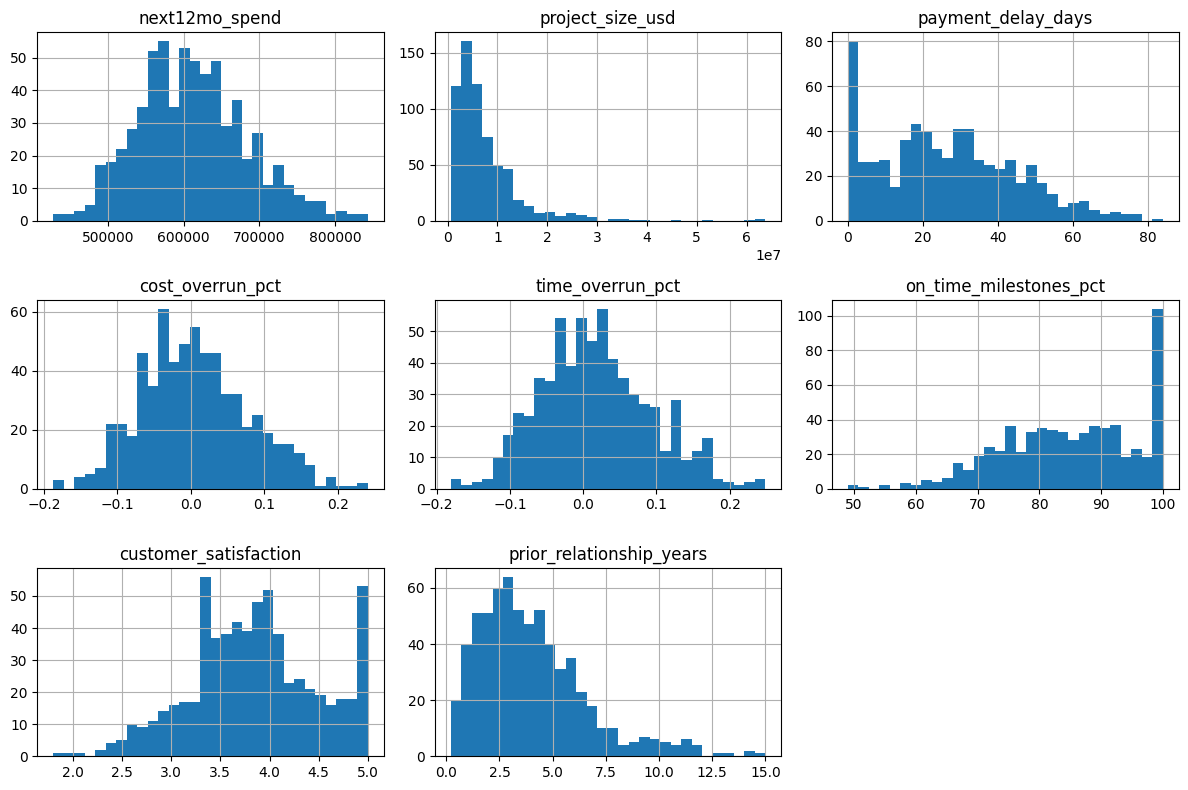

In [34]:

# Quick distributions for key numerics
num_cols = ['next12mo_spend','project_size_usd','payment_delay_days','cost_overrun_pct','time_overrun_pct',
            'on_time_milestones_pct','customer_satisfaction','prior_relationship_years']
df[num_cols].hist(bins=30, figsize=(12,8)); plt.tight_layout(); plt.show()


## Baseline Model (OLS on raw target)

In [35]:

formula = """next12mo_spend ~ 
    np.log(project_size_usd) + scope_complexity + close_time_days
  + prior_relationship_years + competition_count + discount_pct
  + pm_experience_years + safety_incidents + on_time_milestones_pct
  + cost_overrun_pct + time_overrun_pct + payment_delay_days + n_change_orders
  + C(industry) + C(region) + C(project_type) + C(contract_type) + is_union_site
"""

y, X = pt.dmatrices(formula, df, return_type='dataframe')
m0 = sm.OLS(y, sm.add_constant(X, has_constant='add'), missing='drop').fit()
m0.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         next12mo_spend   R-squared:                       0.301
Model:                            OLS   Adj. R-squared:                  0.268
Method:                 Least Squares   F-statistic:                     9.157
Date:                Sat, 27 Sep 2025   Prob (F-statistic):           3.16e-30
Time:                        11:52:31   Log-Likelihood:                -7479.7
No. Observations:                 602   AIC:                         1.502e+04
Df Residuals:                     574   BIC:                         1.514e+04
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
const                                 1.031e+05   2.89e+04      3.570      0.000    4.64e+04     1.6e+05
Intercept                             1.031e+05   2.89e+04      3.570      0.000    4.64e+04     1.6e+05
C(industry)[T.Food&Beverage]           1.87e+04   9821.934      1.904      0.057    -595.064     3.8e+04
C(industry)[T.Healthcare]             2.394e+04   1.01e+04      2.374      0.018    4128.948    4.37e+04
C(industry)[T.Logistics]              1.952e+04   1.03e+04      1.897      0.058    -691.819    3.97e+04
C(industry)[T.Manufacturing]          1.425e+04   9508.161      1.499      0.134   -4422.302    3.29e+04
C(industry)[T.Pharma]                 2.709e+04   1.07e+04      2.528      0.012    6042.972    4.81e+04
C(industry)[T.Technology]             1.449e+04   1.03e+04      1.406      0.160   -5749.589    3.47e+04
C(region)[T.Northeast]                9462.6793   7139.167      1.325      0.186   -4559.398    2.35e+04
C(region)[T.South]                     148.8418   7001.299      0.021      0.983   -1.36e+04    1.39e+04
C(region)[T.West]                     3122.8350   7229.999      0.432      0.666   -1.11e+04    1.73e+04
C(project_type)[T.NewBuild]           1818.0413   7208.201      0.252      0.801   -1.23e+04     1.6e+04
C(project_type)[T.Retrofit]           5498.1309   7258.634      0.757      0.449   -8758.592    1.98e+04
C(project_type)[T.TenantImprovement]  5461.0783   8415.460      0.649      0.517   -1.11e+04     2.2e+04
C(contract_type)[T.FixedBid]          -775.6284   6455.272     -0.120      0.904   -1.35e+04    1.19e+04
C(contract_type)[T.GMP]               7063.5995   7080.180      0.998      0.319   -6842.621     2.1e+04
np.log(project_size_usd)              1.888e+04   3214.876      5.874      0.000    1.26e+04    2.52e+04
scope_complexity                     -4243.3854   3076.859     -1.379      0.168   -1.03e+04    1799.890
close_time_days                        -90.2747     73.458     -1.229      0.220    -234.555      54.005
prior_relationship_years              7632.4748   1023.444      7.458      0.000    5622.322    9642.627
competition_count                    -2992.8080   1422.271     -2.104      0.036   -5786.298    -199.318
discount_pct                          -202.0662   1027.388     -0.197      0.844   -2219.965    1815.832
pm_experience_years                    669.1205    627.423      1.066      0.287    -563.205    1901.446
safety_incidents                     -3.068e+04   3266.424     -9.391      0.000   -3.71e+04   -2.43e+04
on_time_milestones_pct                1340.2972    235.854      5.683      0.000     877.055    1803.539
cost_overrun_pct                      1.506e+04   1.91e+04      0.791      0.429   -2.24e+04    5.25e+04
time_overrun_pct                      

### Diagnostics

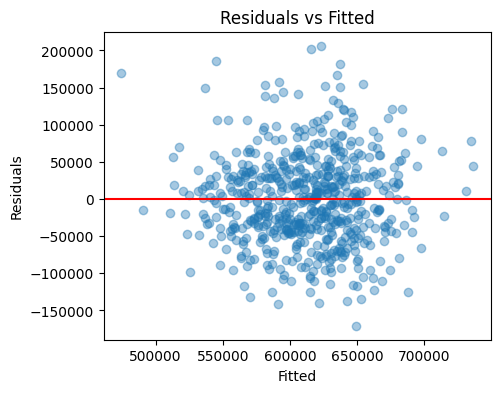

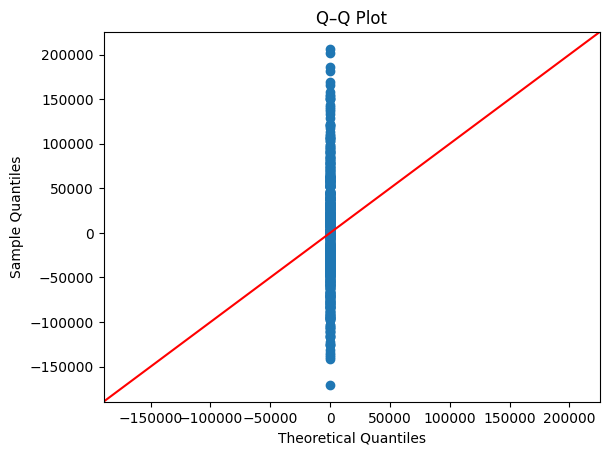

{'LM': np.float64(38.40294316257212),
 'pval': np.float64(0.11363434868665168),
 'F': np.float64(1.4485847913986132),
 'Fpval': np.float64(0.068106548334495)}

In [36]:

resid, fitted = m0.resid.values, m0.fittedvalues.values
plt.figure(figsize=(5,4)); plt.scatter(fitted, resid, alpha=0.4)
plt.axhline(0, color='r'); plt.xlabel("Fitted"); plt.ylabel("Residuals"); plt.title("Residuals vs Fitted"); plt.show()
sm.qqplot(m0.resid, line='45'); plt.title("Q–Q Plot"); plt.show()

bp = het_breuschpagan(m0.resid, m0.model.exog)
{"LM": bp[0], "pval": bp[1], "F": bp[2], "Fpval": bp[3]}


In [37]:

# VIF
import pandas as pd
exog = pd.DataFrame(m0.model.exog, columns=m0.model.exog_names).drop(columns=['const'], errors='ignore')
vif = pd.DataFrame({
    "feature": exog.columns,
    "VIF": [variance_inflation_factor(exog.values, i) for i in range(exog.shape[1])]
}).sort_values("VIF", ascending=False)
vif.head(12)


/Users/paulboal/.pyenv/versions/data5740/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/Users/paulboal/.pyenv/versions/data5740/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,feature,VIF
22,safety_incidents,inf
21,pm_experience_years,inf
24,cost_overrun_pct,inf
25,time_overrun_pct,inf
23,on_time_milestones_pct,inf
16,scope_complexity,inf
4,C(industry)[T.Manufacturing],2.2696
1,C(industry)[T.Food&Beverage],2.0982
3,C(industry)[T.Logistics],1.9717
2,C(industry)[T.Healthcare],1.9711


## Addressing Deficiencies

In [38]:

# 1) Simple imputation for features likely missing
imp_cols = ["on_time_milestones_pct","customer_satisfaction","pm_experience_years","discount_pct"]
df_imp = df.copy()
df_imp[imp_cols] = SimpleImputer(strategy='median').fit_transform(df_imp[imp_cols])

# 2) Optional transform of target to reduce heteroscedasticity (log dollars)
df_imp = df_imp[df_imp['next12mo_spend']>0].copy()
df_imp['log_spend'] = np.log(df_imp['next12mo_spend'])

formula_log = formula.replace("next12mo_spend","log_spend")
yL, XL = pt.dmatrices(formula_log, df_imp, return_type='dataframe')
m1 = sm.OLS(yL, sm.add_constant(XL, has_constant='add')).fit()
m1.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_spend   R-squared:                       0.288
Model:                            OLS   Adj. R-squared:                  0.256
Method:                 Least Squares   F-statistic:                     8.962
Date:                Sat, 27 Sep 2025   Prob (F-statistic):           9.49e-31
Time:                        11:52:31   Log-Likelihood:                 578.45
No. Observations:                 650   AIC:                            -1099.
Df Residuals:                     621   BIC:                            -969.1
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
const                                    6.2574      0.085     73.631      0.000       6.090       6.424
Intercept                                6.2574      0.085     73.631      0.000       6.090       6.424
C(industry)[T.Food&Beverage]             0.0288      0.016      1.852      0.065      -0.002       0.059
C(industry)[T.Healthcare]                0.0364      0.016      2.273      0.023       0.005       0.068
C(industry)[T.Logistics]                 0.0270      0.016      1.649      0.100      -0.005       0.059
C(industry)[T.Manufacturing]             0.0232      0.015      1.550      0.122      -0.006       0.053
C(industry)[T.Pharma]                    0.0394      0.017      2.330      0.020       0.006       0.073
C(industry)[T.Technology]                0.0218      0.017      1.323      0.186      -0.011       0.054
C(region)[T.Northeast]                   0.0109      0.011      0.965      0.335      -0.011       0.033
C(region)[T.South]                       0.0014      0.011      0.128      0.898      -0.020       0.023
C(region)[T.West]                        0.0030      0.011      0.264      0.792      -0.019       0.026
C(project_type)[T.NewBuild]              0.0016      0.011      0.138      0.890      -0.021       0.024
C(project_type)[T.Retrofit]              0.0091      0.012      0.786      0.432      -0.014       0.032
C(project_type)[T.TenantImprovement]     0.0127      0.013      0.959      0.338      -0.013       0.039
C(contract_type)[T.FixedBid]            -0.0053      0.010     -0.514      0.608      -0.025       0.015
C(contract_type)[T.GMP]                  0.0050      0.011      0.444      0.657      -0.017       0.027
np.log(project_size_usd)                 0.0292      0.005      5.714      0.000       0.019       0.039
scope_complexity                        -0.0306      0.020     -1.506      0.133      -0.071       0.009
close_time_days                         -0.0002      0.000     -1.517      0.130      -0.000    5.21e-05
prior_relationship_years                 0.0121      0.002      7.552      0.000       0.009       0.015
competition_count                       -0.0051      0.002     -2.290      0.022      -0.010      -0.001
discount_pct                            -0.0011      0.002     -0.694      0.488      -0.004       0.002
pm_experience_years                     -0.0043      0.004     -1.048      0.295      -0.012       0.004
safety_incidents                        -0.0751      0.021     -3.627      0.000      -0.116      -0.034
on_time_milestones_pct                   0.0052      0.002      2.154      0.032       0.000       0.010
cost_overrun_pct                        -5.1781      3.942     -1.314      0.189     -12.920       2.563
time_overrun_pct                      

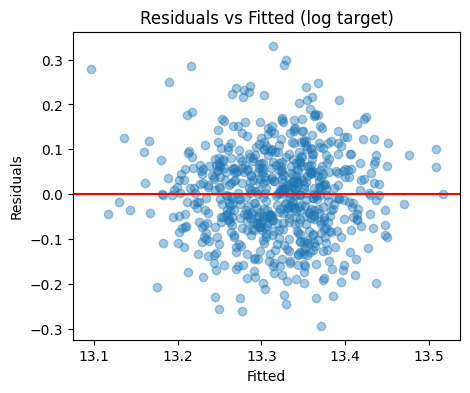

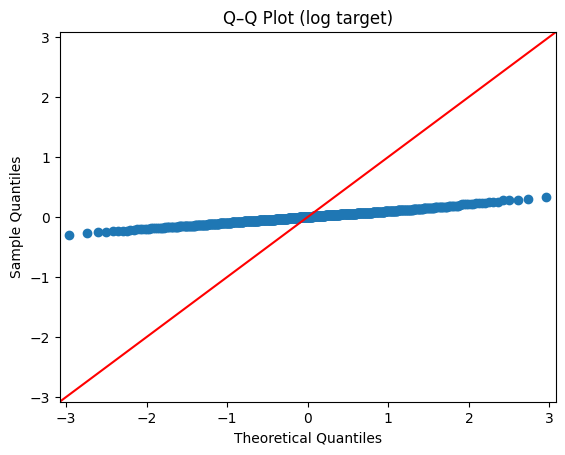

In [39]:

# Diagnostics on log model
resid, fitted = m1.resid.values, m1.fittedvalues.values
plt.figure(figsize=(5,4)); plt.scatter(fitted, resid, alpha=0.4)
plt.axhline(0, color='r'); plt.xlabel("Fitted"); plt.ylabel("Residuals"); plt.title("Residuals vs Fitted (log target)"); plt.show()
sm.qqplot(m1.resid, line='45'); plt.title("Q–Q Plot (log target)"); plt.show()


## Regularization sanity-check (stability, not the main grading focus)

In [40]:

# Build design matrix for sklearn (drop NA on used cols after imputation)
y_reg, X_reg = pt.dmatrices(formula, df_imp, return_type='dataframe')
y_reg = y_reg.values.ravel()

ridge = Pipeline([('scale', StandardScaler(with_mean=False)),  # with_mean=False for sparse design matrix from patsy
                  ('model', RidgeCV(alphas=np.logspace(-3,3,50), cv=5))])
lasso = Pipeline([('scale', StandardScaler(with_mean=False)),
                  ('model', LassoCV(alphas=np.logspace(-3,1,50), cv=5, max_iter=20000))])

cv = KFold(n_splits=5, shuffle=True, random_state=7)
ridge.fit(X_reg, y_reg); lasso.fit(X_reg, y_reg)
ridge_cv_r2 = cross_val_score(ridge, X_reg, y_reg, cv=cv, scoring='r2').mean()
lasso_cv_r2 = cross_val_score(lasso, X_reg, y_reg, cv=cv, scoring='r2').mean()

ridge_alpha = ridge.named_steps['model'].alpha_
lasso_alpha = lasso.named_steps['model'].alpha_
ridge_cv_r2, lasso_cv_r2, ridge_alpha, lasso_alpha


/Users/paulboal/.pyenv/versions/data5740/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8547201332.113281, tolerance: 286073232.76730776
  model = cd_fast.enet_coordinate_descent_gram(
/Users/paulboal/.pyenv/versions/data5740/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 356233203.6328125, tolerance: 261932099.46923083
  model = cd_fast.enet_coordinate_descent_gram(
/Users/paulboal/.pyenv/versions/data5740/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 359921763.46777344, tolerance: 261932099.46923083
  model = cd_fast.enet_coordinate_descent_gram(
/Users/pa

(np.float64(0.17930057683000175),
 np.float64(0.16893286927911866),
 np.float64(79.06043210907701),
 np.float64(0.001))

## Interpretation (example bullets)


- **Project size & satisfaction are strong positive drivers** of next-12-month spend (elasticity visible in log/level models).
- **Cost/time overruns and payment delays reduce spend**, aligning with operational intuition.
- **Prior relationship & on-time milestones** are positively associated with retention revenue.
- Certain **industries/regions** carry meaningful fixed effects consistent with cost/market dynamics.
- Practical takeaways: (1) tighten schedule/cost controls, (2) staff experienced PMs, (3) invest in on-time milestone processes, (4) prioritize accounts with strong prior relationships and high satisfaction for expansion.
